<a href="https://colab.research.google.com/github/damar3c50/diamond/blob/main/Diamond_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (KFold, train_test_split, GridSearchCV, cross_val_score)
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import learning_curve
import pickle
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/diamonds.csv')
df.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

- price: price in US dollars (\$326--\$18,823)

- carat: weight of the diamond (0.2--5.01)

- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- color: diamond colour, from J (worst) to D (best)

- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- x: length in mm (0--10.74)

- y: width in mm (0--58.9)

- z: depth in mm (0--31.8)

- depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- table: width of top of diamond relative to widest point (43--95)

In [ ]:
df.shape

(53940, 11)

#Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


**Drop kolom Unnamed: 0**

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.head()

carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75

**Check Duplicate**

In [ ]:
duplicated_rows = df[df.duplicated(keep=False)].groupby(df.columns.tolist()).size().reset_index(name='count')
print(duplicated_rows)

     carat        cut color clarity  depth  table  price     x     y     z  \
0     0.30       Good     J     VS1   63.4   57.0    394  4.23  4.26  2.69   
1     0.30      Ideal     G      IF   62.1   55.0    863  4.32  4.35  2.69   
2     0.30      Ideal     G     VS2   63.0   55.0    675  4.31  4.29  2.71   
3     0.30      Ideal     H     SI1   62.2   57.0    450  4.26  4.29  2.66   
4     0.30      Ideal     H     SI1   62.2   57.0    450  4.27  4.28  2.66   
..     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
138   2.50       Fair     H     SI2   64.9   58.0  13278  8.46  8.43  5.48   
139   2.54  Very Good     H     SI2   63.5   56.0  16353  8.68  8.65  5.50   
140   2.66       Good     H     SI2   63.8   57.0  16239  8.71  8.65  5.54   
141   3.01       Fair     I     SI2   65.8   56.0  18242  8.99  8.94  5.90   
142   3.01       Good     I     SI2   63.9   60.0  18242  9.06  9.01  5.77   

     count  
0        2  
1        2  
2        2  
3        2 

**Drop duplicate values**

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53794 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53794 non-null  float64
 1   cut      53794 non-null  object 
 2   color    53794 non-null  object 
 3   clarity  53794 non-null  object 
 4   depth    53794 non-null  float64
 5   table    53794 non-null  float64
 6   price    53794 non-null  int64  
 7   x        53794 non-null  float64
 8   y        53794 non-null  float64
 9   z        53794 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


**Check Outliers**

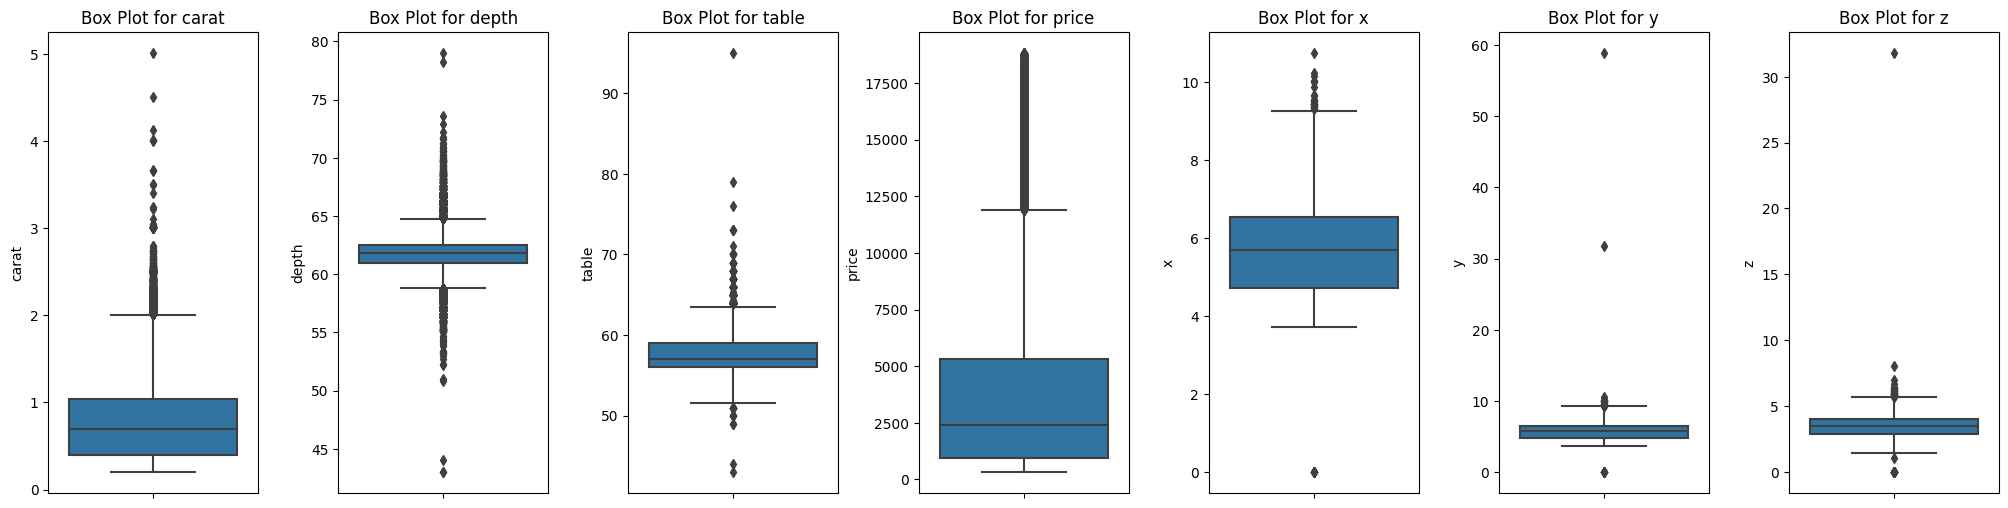

In [ ]:
num_cols = df.select_dtypes(exclude=['object']).columns

fig, axs = plt.subplots(ncols=len(num_cols), figsize=(20,5))

for i, column in enumerate(num_cols):
  sns.boxplot(y=column, data=df, ax=axs[i], whis=1.5)

  axs[i].set_title(f'Box Plot for {column}')
  axs[i].set_xlabel('')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()

In [ ]:
#Calculate the first quantile(Q1)
Q1 = df[num_cols].quantile(0.25)

#Calculate the third quantile(Q3)
Q3 = df[num_cols].quantile(0.75)

#Calculate IQR
IQR = Q3 - Q1

#Define threshold
threshold = 1.5

#Calculate lower & upper bound
lower_bound = Q1 - (threshold * IQR)
upper_bound = Q3 + (threshold * IQR)

#Count the number of outliers
outliers_count = ((df.select_dtypes(exclude=['object']) < lower_bound) | (df.select_dtypes(exclude=['object']) > upper_bound)).sum()
#Calculate the total rows
total_rows = len(df)

#Percentage Outliers
percentage_outliers = (outliers_count/total_rows) * 100
#Create a dataframe
final_outliers = pd.DataFrame({'Column': df.select_dtypes(exclude=['object']).columns, 'Outliers': outliers_count, 'Percentage Outliers':percentage_outliers})
print(final_outliers)

      Column  Outliers  Percentage Outliers
carat  carat      1873             3.481801
depth  depth      2525             4.693832
table  table       604             1.122802
price  price      3523             6.549058
x          x        31             0.057627
y          y        28             0.052050
z          z        48             0.089229


In [ ]:
df.describe()

carat         depth         table         price             x  \
count  53794.00000  53794.000000  53794.000000  53794.000000  53794.000000   
mean       0.79778     61.748080     57.458109   3933.065082      5.731214   
std        0.47339      1.429909      2.233679   3988.114460      1.120695   
min        0.20000     43.000000     43.000000    326.000000      0.000000   
25%        0.40000     61.000000     56.000000    951.000000      4.710000   
50%        0.70000     61.800000     57.000000   2401.000000      5.700000   
75%        1.04000     62.500000     59.000000   5326.750000      6.540000   
max        5.01000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53794.000000  53794.000000  
mean       5.734653      3.538714  
std        1.141209      0.705037  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000      4.030000  
max       58.900000     31.800000

In [ ]:
'''
#Handle Outlier with Capping
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
max = Q3 + (1.5 * IQR)
min = Q1 - (1.5 * IQR)

df[num_cols] = df[num_cols].clip(lower=min, upper=max, axis=1)
print(df[num_cols].describe())
'''

'\n#Handle Outlier with Capping\nQ1 = df[num_cols].quantile(0.25)\nQ3 = df[num_cols].quantile(0.75)\nIQR = Q3 - Q1\nmax = Q3 + (1.5 * IQR)\nmin = Q1 - (1.5 * IQR)\n\ndf[num_cols] = df[num_cols].clip(lower=min, upper=max, axis=1)\nprint(df[num_cols].describe())\n'

In [ ]:
'''
fig, axs = plt.subplots(ncols=len(num_cols), figsize=(20, 5))
for i, column in enumerate(num_cols):
  sns.boxplot(y=column, data=df, ax=axs[i])

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.show()
'''

'\nfig, axs = plt.subplots(ncols=len(num_cols), figsize=(20, 5))\nfor i, column in enumerate(num_cols):\n  sns.boxplot(y=column, data=df, ax=axs[i])\n\nplt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)\nplt.show()\n'

#EDA

###Univariate Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


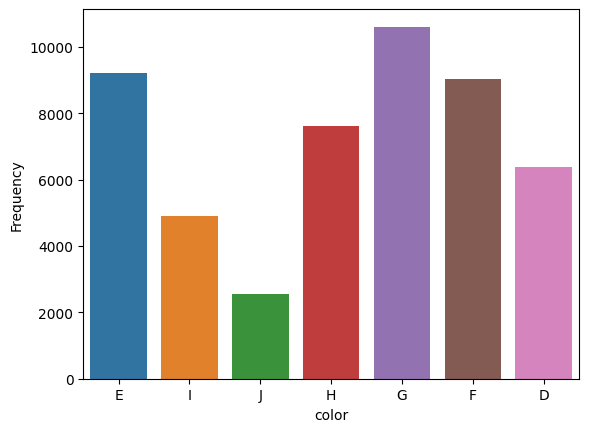

In [ ]:
def countplot(df, x):
  x_var = x
  sns.countplot(data=df, x=x_var)
  plt.ylabel('Frequency')
  plt.show()

countplot(df, 'color')
#J (worst) to D (best)

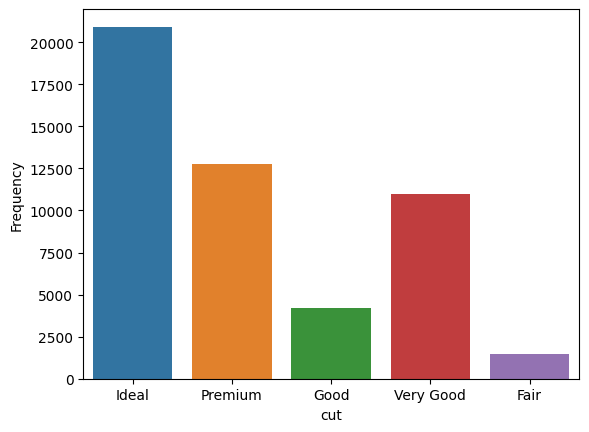

In [ ]:
countplot(df, 'cut')
#(Fair, Good, Very Good, Premium, Ideal)

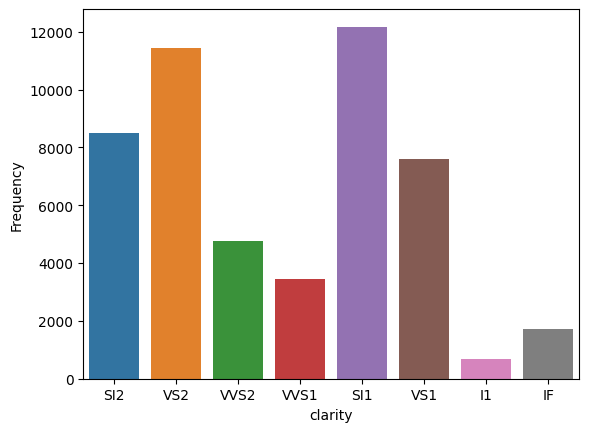

In [ ]:
countplot(df, 'clarity')

#(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

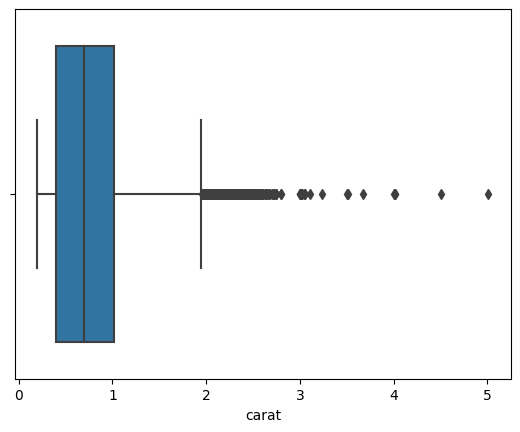

In [ ]:
def boxplot(df, x):
  sns.boxplot(data=df, x=x)

boxplot(df, 'carat')

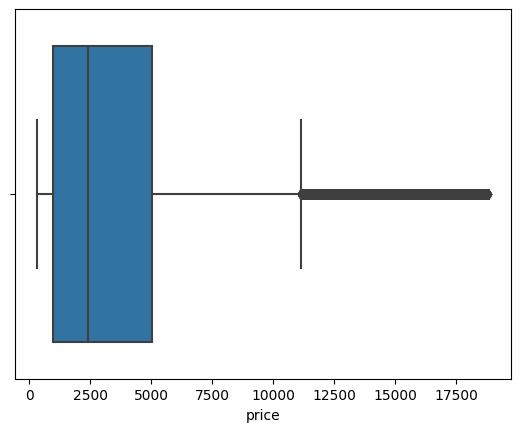

In [ ]:
boxplot(df, 'price')

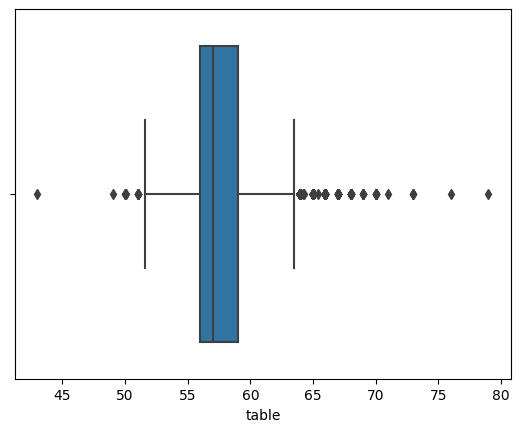

In [ ]:
boxplot(df, 'table')

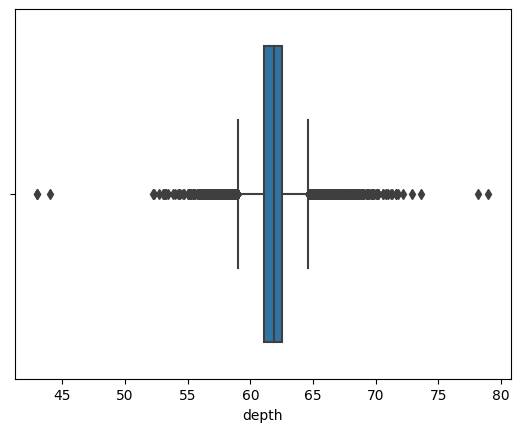

In [ ]:
boxplot(df, 'depth')

###Bivariate Analysis

Numerical vs Numerical

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


In [ ]:
def scatter_plot(x, y):
  fig = px.scatter(df, x=x, y=y, title=f'Scatter Plot: {x} vs {y}')
  fig.show()

scatter_plot('carat', 'price')

In [ ]:
scatter_plot('table', 'carat')

In [ ]:
scatter_plot('price', 'table')

In [ ]:
scatter_plot('price', 'depth')

In [ ]:
scatter_plot('carat', 'depth')

In [ ]:
corr_cols = df.select_dtypes(exclude=['object']).corr()

#Create a heatmap for correlation
fig = px.imshow(corr_cols,
                x=corr_cols.columns,
                y=corr_cols.columns,
                color_continuous_scale='Blues',
                title='Correlation Heatmap')

fig.update_layout(width=800, height=600)
fig.show()

Categorical vs Numerical

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


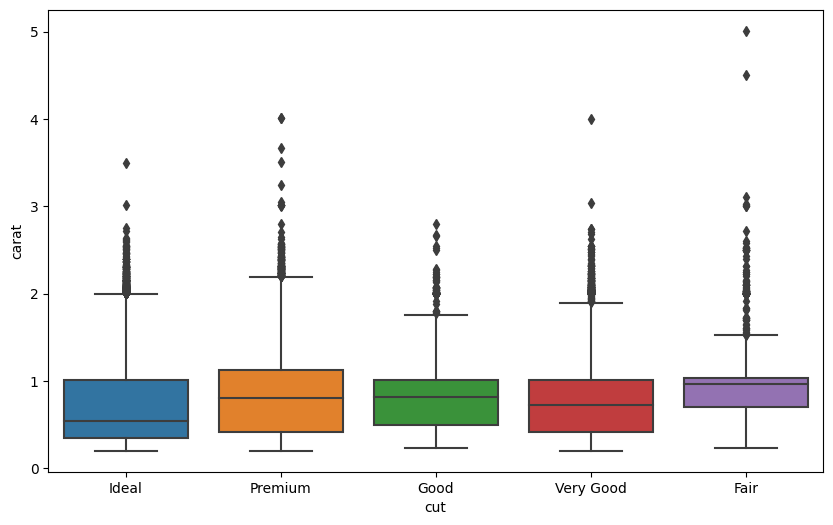

In [ ]:
def catnu(x, y):
  plt.figure(figsize=(10,6))
  sns.boxplot(x=x, y=y, data=df)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()

catnu('cut', 'carat')

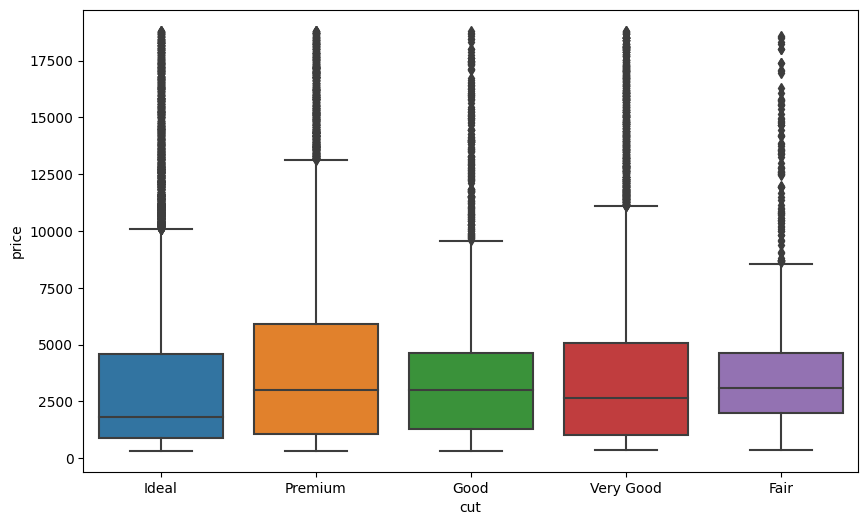

In [ ]:
catnu('cut', 'price')

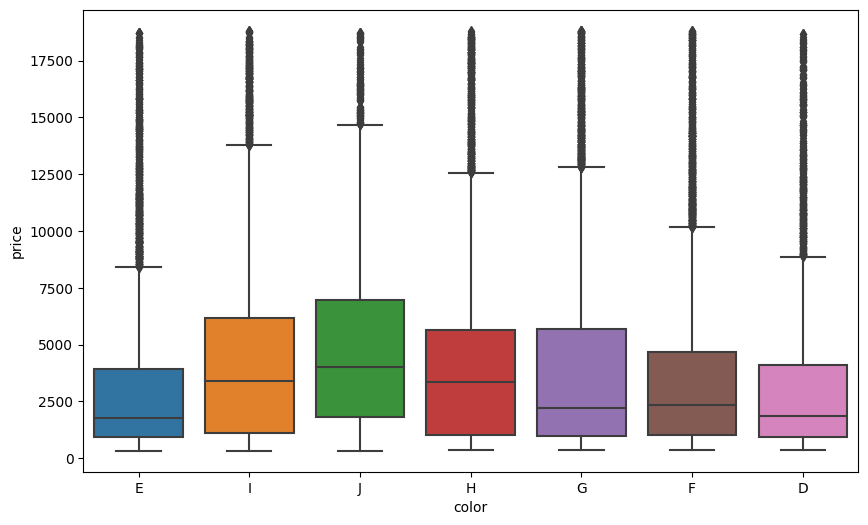

In [ ]:
catnu('color', 'price')

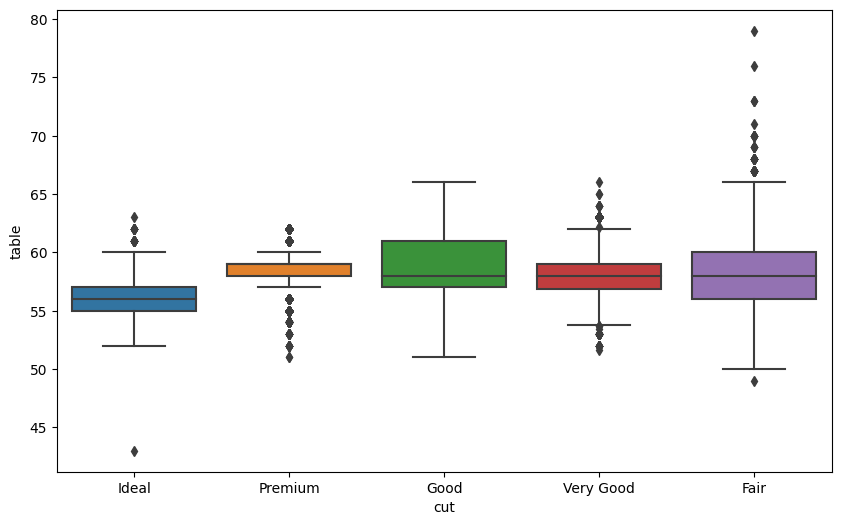

In [ ]:
catnu('cut', 'table')

Categorical vs Categorical

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


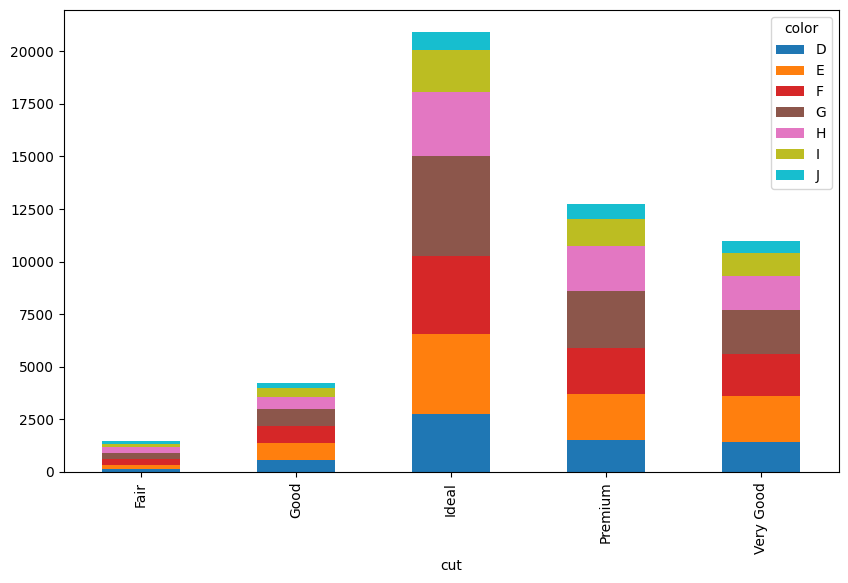

In [ ]:
def catcat(x, y):
  cross_tab = pd.crosstab(index=df[x],
                          columns=df[y])
  cross_tab.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10,6))
  plt.show()


catcat('cut', 'color')

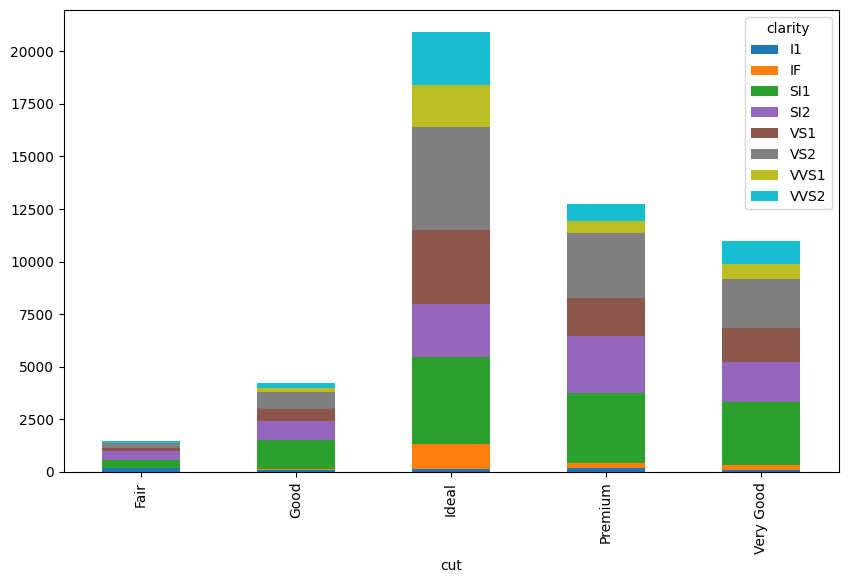

In [ ]:
catcat('cut', 'clarity')

**Interpretasi**

- fitur table dan depth merupakan data kategori
- fitur x, y, z memiliki korelasi yang tinggi dan bisa dipertimbangkan untuk di drop untuk mencegah overfitting

###Multivariate Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


In [ ]:
def multivariate(x, y, z):
  fig = px.scatter(df, x=x, y=y, color=z,
                   title=f'Scatter Plot: {x} vs {y} (Colored by {z})')
  fig.show()

multivariate('carat', 'price', 'cut')

In [ ]:
multivariate('carat', 'price', 'clarity')

In [ ]:
multivariate('carat', 'price', 'color')

In [ ]:
multivariate('price', 'table', 'clarity')

In [ ]:
multivariate('price', 'table', 'cut')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50314 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50314 non-null  float64
 1   cut      50314 non-null  object 
 2   color    50314 non-null  object 
 3   clarity  50314 non-null  object 
 4   depth    50314 non-null  float64
 5   table    50314 non-null  float64
 6   price    50314 non-null  int64  
 7   x        50314 non-null  float64
 8   y        50314 non-null  float64
 9   z        50314 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.2+ MB


In [ ]:
def multi2(x, y, z, xyz, color):
  fig = px.scatter(df, x=x, y=y, color=color,
                   size=z, hover_data=xyz)
  fig.show()

multi2('carat', 'table', 'price', 'depth', 'cut')

**Interpretasi**

- fitur color, carat, clarity bisa dijadikan variabel utama dalam memprediksi harga dari suatu diamond
- semakin bagus warna diamond, semakin tinggi carat, dan semakin tinggi tingkat kemurnian maka harga suatu diamond semakin tinggi dan berlaku sebaliknya


#Feature Engineering

**Encode Numeric and Category**

In [ ]:
df.head()

carat        cut color clarity  depth  table  price     x     y     z
0   0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
3   0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
5   0.24  Very Good     J    VVS2   62.8   57.0    336  3.94  3.96  2.48
6   0.24  Very Good     I    VVS1   62.3   57.0    336  3.95  3.98  2.47

In [ ]:
df_scale = df.copy()

In [ ]:
std_scale = StandardScaler()
std_scale

StandardScaler()

In [ ]:
num_cols = df_scale.select_dtypes(exclude=['object']).columns

for i in num_cols:
  df_scale[i] = std_scale.fit_transform(df[[i]])

df_scale.head()


carat        cut color clarity     depth     table     price         x  \
0 -1.229634      Ideal     E     SI2 -0.208432 -1.126780 -0.911696 -1.636780   
3 -1.095820    Premium     I     VS2  0.449452  0.297765 -0.909578 -1.403638   
4 -1.051215       Good     J     SI2  1.107335  0.297765 -0.909313 -1.273079   
5 -1.207331  Very Good     J    VVS2  0.741844 -0.177083 -0.909048 -1.646105   
6 -1.207331  Very Good     I    VVS1  0.376354 -0.177083 -0.909048 -1.636780   

          y         z  
0 -1.576591 -1.612837  
3 -1.348659 -1.318368  
4 -1.239251 -1.141686  
5 -1.594825 -1.539220  
6 -1.576591 -1.553943

In [ ]:
cat_encoder = OrdinalEncoder()

cat_cols = df_scale.select_dtypes(include=['object'])

for i in cat_cols:
  df_scale[i] = cat_encoder.fit_transform(df_scale[[i]])

df_scale.head()

carat  cut  color  clarity     depth     table     price         x  \
0 -1.229634  2.0    1.0      3.0 -0.208432 -1.126780 -0.911696 -1.636780   
3 -1.095820  3.0    5.0      5.0  0.449452  0.297765 -0.909578 -1.403638   
4 -1.051215  1.0    6.0      3.0  1.107335  0.297765 -0.909313 -1.273079   
5 -1.207331  4.0    6.0      7.0  0.741844 -0.177083 -0.909048 -1.646105   
6 -1.207331  4.0    5.0      6.0  0.376354 -0.177083 -0.909048 -1.636780   

          y         z  
0 -1.576591 -1.612837  
3 -1.348659 -1.318368  
4 -1.239251 -1.141686  
5 -1.594825 -1.539220  
6 -1.576591 -1.553943

In [ ]:
df_scale['color'].value_counts()

3.0    10607
1.0     9213
2.0     9026
4.0     7629
0.0     6377
5.0     4904
6.0     2558
Name: color, dtype: int64

In [ ]:
'''
Color:
 D 0
 E 1
 F 2
 G 3
 H 4
 I 5
 J 6

from J (worst) to D (best)
'''

'\nColor:\n D 0\n E 1\n F 2\n G 3\n H 4\n I 5\n J 6\n\nfrom J (worst) to D (best)\n'

In [ ]:
df_scale['clarity'].value_counts()

2.0    12174
5.0    11447
3.0     8486
4.0     7613
7.0     4763
6.0     3438
1.0     1706
0.0      687
Name: clarity, dtype: int64

In [ ]:
'''
Clarity:
 I1 0
 S12 3
 SI1 2
 VS2 5
 VS1 4
 VVS2 7
 VVS1 6
 IF 1

(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
'''

'\nClarity:\n I1 0\n S12 3\n SI1 2\n VS2 5\n VS1 4\n VVS2 7\n VVS1 6\n IF 1\n\n(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))\n'

In [ ]:
df_scale['cut'].value_counts()

2.0    20918
3.0    12746
4.0    10987
1.0     4220
0.0     1443
Name: cut, dtype: int64

Drop Unnecessary Columns

In [ ]:
numeric_cols = df_scale.select_dtypes(exclude=['object']).corr()

fig = px.imshow(numeric_cols,
                x=numeric_cols.columns,
                y=numeric_cols.columns,
                color_continuous_scale = 'Viridis')

fig.update_layout(width=800, height=600)
fig.show()

In [ ]:
df_scale.drop(['x', 'y', 'z'], axis=1, inplace=True)
df_scale.head()

carat  cut  color  clarity     depth     table     price
0 -1.229634  2.0    1.0      3.0 -0.208432 -1.126780 -0.911696
3 -1.095820  3.0    5.0      5.0  0.449452  0.297765 -0.909578
4 -1.051215  1.0    6.0      3.0  1.107335  0.297765 -0.909313
5 -1.207331  4.0    6.0      7.0  0.741844 -0.177083 -0.909048
6 -1.207331  4.0    5.0      6.0  0.376354 -0.177083 -0.909048

In [ ]:
corr_new = df_scale.select_dtypes(exclude=['object']).corr()

fig = px.imshow(corr_new,
                x=corr_new.columns,
                y=corr_new.columns,
                color_continuous_scale='Blues')

fig.update_layout(width=800, height=600)
fig.show()

Feature Importance with Random Forest

In [ ]:
X = df_scale.drop(['price'], axis=1)
y = df_scale['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((40251, 6), (10063, 6))

In [ ]:
clf = RandomForestRegressor(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
features_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_scores

carat      0.879526
clarity    0.073913
color      0.031925
depth      0.008162
table      0.003909
cut        0.002564
dtype: float64

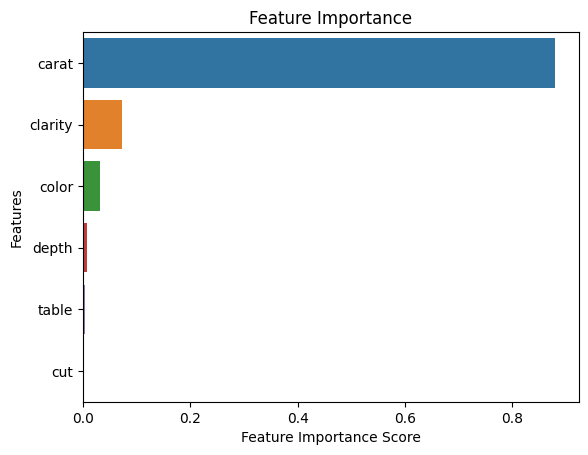

In [ ]:
sns.barplot(x=features_scores, y=features_scores.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.title('Feature Importance')

plt.show()

**Interpretasi**

- Sebelum dilakukan modeling, data dilakukan scalling menggunakan standart scaler alasan menggunakan standart scaler yakni tidak ada hanya preferensi dari analis
- Selanjutnya cek korelasi antar variabel, variabel x, y, z memiliki nilai korelasi yang tinggi dan kenapa dihapus? karena mencegah overfitting ketika nanti dimodelling
- Melakukan feature importance yang hasilnya akan digunakan untuk modeling, fitur yang masuk dalam modelling hanya 3 yakni carat, clarity, color hal ini sejalan dengan hasil EDA pada multivariate analysis

#Modelling

In [ ]:
df_mod = df_scale.copy()

In [ ]:
X = df_mod[['carat', 'clarity', 'color']]
y = df_mod['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((40251, 3), (10063, 3))

In [ ]:
X_train

carat  clarity  color
24168  1.602758      2.0    0.0
11579  0.264620      2.0    0.0
48532 -0.605169      5.0    0.0
17854  1.535851      5.0    6.0
36767 -0.872797      4.0    2.0
...         ...      ...    ...
11532  0.599154      2.0    4.0
48270 -0.560565      5.0    0.0
41541 -0.805890      4.0    0.0
895    0.487643      3.0    4.0
16405  0.955991      2.0    3.0

[40251 rows x 3 columns]

In [ ]:
y_train

24168    2.270015
11579    0.336522
48532   -0.472145
17854    0.909262
36767   -0.744879
           ...   
11532    0.333080
48270   -0.480089
41541   -0.671002
895     -0.236747
16405    0.736089
Name: price, Length: 40251, dtype: float64

Cross Validation

In [ ]:
models = [
    ('LR', LinearRegression()),
    ('RF', RandomForestRegressor()),
    ('DT', DecisionTreeRegressor())
]

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_result = cross_val_score(model, X, y, cv=kfold, scoring=make_scorer(r2_score))
  results.append(cv_result)
  names.append(name)
  print(name, cv_result.mean())

LR 0.8725942070785211
RF 0.9764585795763854
DT 0.9738546232381651


Grid Search

In [ ]:
'''
rf_model = RandomForestRegressor()

rf_params = {
    'n_estimators':[50, 100, 50],
    'max_features':[1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'max_depth': [2, 4, 6]
}

rf_cv_model = GridSearchCV(
    rf_model,
    rf_params,
    cv=5,
    n_jobs=-1,
    verbose=2
).fit(X, y)

print(rf_cv_model.best_params_)
'''


"\nrf_model = RandomForestRegressor()\n\nrf_params = {\n    'n_estimators':[50, 100, 50],\n    'max_features':[1, 2, 3],\n    'min_samples_split': [1, 2, 3],\n    'max_depth': [2, 4, 6]\n}\n\nrf_cv_model = GridSearchCV(\n    rf_model,\n    rf_params,\n    cv=5,\n    n_jobs=-1,\n    verbose=2\n).fit(X, y)\n\nprint(rf_cv_model.best_params_)\n"

In [ ]:
#rf_tuned = RandomForestRegressor(**rf_cv_model.best_params_).fit(X, y)

In [ ]:
'''
dt_model = DecisionTreeRegressor()

dt_params = {"splitter":["best","random"],
            "max_depth" : [1,3,5,7],
           "min_samples_leaf":[1,2,3,4,5]}


dt_cv_model = GridSearchCV(
    dt_model,
    dt_params,
    cv=5,
    n_jobs=-1,
    verbose=2
).fit(X, y)

print(dt_cv_model.best_params_)
'''

'\ndt_model = DecisionTreeRegressor()\n\ndt_params = {"splitter":["best","random"],\n            "max_depth" : [1,3,5,7],\n           "min_samples_leaf":[1,2,3,4,5]}\n\n\ndt_cv_model = GridSearchCV(\n    dt_model,\n    dt_params,\n    cv=5,\n    n_jobs=-1,\n    verbose=2\n).fit(X, y)\n\nprint(dt_cv_model.best_params_)\n'

In [ ]:
#dt_tuned = DecisionTreeRegressor(**dt_cv_model.best_params_).fit(X, y)

In [ ]:
'''
models = [

    ('RF', rf_tuned),
    ('DT', dt_tuned)

]

results = []
names = []

for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)
  cv_result = cross_val_score(model, X, y, cv=kfold)
  results.append(cv_result)
  names.append(name)
  print(name, cv_result.mean())
'''

"\nmodels = [\n\n    ('RF', rf_tuned),\n    ('DT', dt_tuned)\n\n]\n\nresults = []\nnames = []\n\nfor name, model in models:\n  kfold = KFold(n_splits=5, shuffle=True, random_state=42)\n  cv_result = cross_val_score(model, X, y, cv=kfold)\n  results.append(cv_result)\n  names.append(name)\n  print(name, cv_result.mean())\n"

Modelling

In [ ]:
#Random Forest

random_forest = RandomForestRegressor(max_depth= 6, max_features= 2, min_samples_split= 2, n_estimators= 50, random_state=42)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test)


In [ ]:
print("Train Accuracy:",random_forest.score(X_train, y_train))
print("Test Accuracy:",random_forest.score(X_test, y_test))

Train Accuracy: 0.9565689948355016
Test Accuracy: 0.9569265331644156


In [ ]:
print(mean_squared_error(y_test, random_forest_pred)) #MSE
print(mean_squared_error(y_test, random_forest_pred, squared=False)) #RMSE
print(mean_absolute_error(y_test, random_forest_pred)) #MAE

0.0417000936091875
0.20420600776957445
0.11570532672139174


<Axes: >

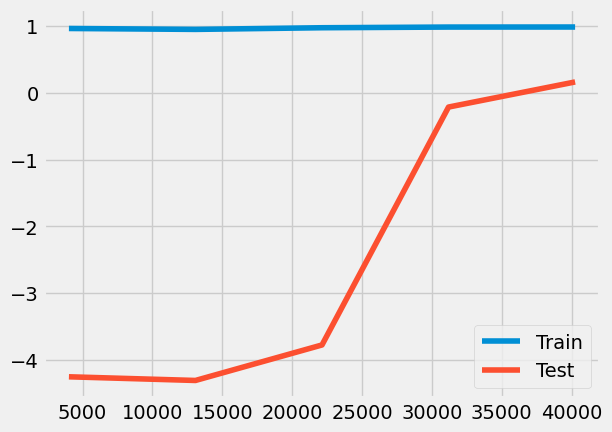

In [ ]:
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import learning_curve

train_sizes_rf, train_scores_rf, valid_scores_rf = learning_curve(RandomForestRegressor(), X, y,
                                                         train_sizes=np.linspace(0.1, 1.0, 5),
                                                         cv=5,
                                                         scoring=make_scorer(r2_score))

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

ax = pd.Series(train_scores_rf.mean(axis=1)).to_frame().set_index(train_sizes_rf)\
                .rename(columns={0: 'Train'}).plot.line()
pd.Series(valid_scores_rf.mean(axis=1)).to_frame().set_index(train_sizes_rf).rename(columns={0: 'Test'})\
                .plot.line(ax=ax)

In [ ]:
random_forest_pred = random_forest.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': random_forest_pred})
df

Actual  Predicted
5089  -0.003997   0.238931
39870 -0.706219  -0.669468
39081 -0.717341  -0.707346
23642  2.091018   1.814560
34375 -0.769504  -0.744852
...         ...        ...
39792 -0.708073  -0.711900
11137  0.309778   0.301915
47447 -0.506303  -0.543609
30594 -0.803662  -0.776968
41842 -0.665971  -0.743783

[10063 rows x 2 columns]

In [ ]:
#Decision Tree
decision_tree = DecisionTreeRegressor(max_depth=7, min_samples_leaf= 5, splitter='best', random_state=42)
decision_tree.fit(X_train, y_train)
decision_tree_pred = decision_tree.predict(X_test)


In [ ]:
print("Train Accuracy:",decision_tree.score(X_train, y_train))
print("Test Accuracy:",decision_tree.score(X_test, y_test))

Train Accuracy: 0.9628660288171571
Test Accuracy: 0.9625942250859988


In [ ]:
print(mean_squared_error(y_test, decision_tree_pred)) #MSE
print(mean_squared_error(y_test, decision_tree_pred, squared=False)) #RMSE
print(mean_absolute_error(y_test, decision_tree_pred)) #MAE

0.036213112851864154
0.19029743259398996
0.10795093933260247


<Axes: >

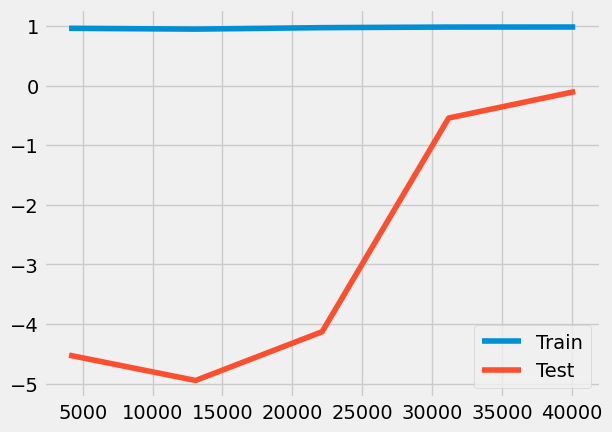

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(DecisionTreeRegressor(), X, y,
                                                         train_sizes=np.linspace(0.1, 1.0, 5),
                                                         cv=5,
                                                         scoring=make_scorer(r2_score))

plt.style.use('fivethirtyeight')

ax = pd.Series(train_scores.mean(axis=1)).to_frame().set_index(train_sizes)\
                .rename(columns={0: 'Train'}).plot.line()
pd.Series(valid_scores.mean(axis=1)).to_frame().set_index(train_sizes).rename(columns={0: 'Test'})\
                .plot.line(ax=ax)

In [ ]:
decision_tree_pred = decision_tree.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': decision_tree_pred})
df

Actual  Predicted
5089  -0.003997   0.109966
39870 -0.706219  -0.667520
39081 -0.717341  -0.674517
23642  2.091018   2.147840
34375 -0.769504  -0.743112
...         ...        ...
39792 -0.708073  -0.713717
11137  0.309778   0.149546
47447 -0.506303  -0.551672
30594 -0.803662  -0.801254
41842 -0.665971  -0.801254

[10063 rows x 2 columns]